<a href="https://colab.research.google.com/github/madhuselvaraj/workspace-python-pandas/blob/master/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import utilities

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=c65c0e4043c017c7919c1d7c47e37c28b48cd48ba203d29eb7ad3ee7bb9f1c62
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


In [3]:
from keras.models import load_model
from PIL import Image
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from numpy import expand_dims
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
from matplotlib import pyplot


Using TensorFlow backend.


load pre trained model of facenet

In [4]:
# load the model
model = load_model('/content/drive/My Drive/facenet_keras.h5')

# summarize input and output shape
print(model.inputs)
print(model.outputs)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


extracting face from images using MTCNN

In [0]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
  #Input : image file name,size of the file
  #Output : array of cropped images
  
  # load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
  
	return face_array

In [0]:
# load images and extract faces for all images in a directory
def load_faces(directory):
  #Input :image directory name 
  #Output : array of input images
  
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
    
	return faces

In [0]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
  
  #Input :directory name which has sub directories
  #Output :array of input images and labels
  
	X, y = list(), list()
	
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]		
		print('>loaded %d examples for class: %s' % (len(faces), subdir))		
		X.extend(faces)
		y.extend(labels)
    
	return asarray(X), asarray(y)

compress array of train and test images.

In [0]:
train_dir = '/content/drive/My Drive/Dataset_GOI/train/'
test_dir = '/content/drive/My Drive/Dataset_GOI/test/'

In [10]:
# load train dataset
trainX, trainy = load_dataset(train_dir)
print(trainX.shape, trainy.shape)

# load test dataset
testX, testy = load_dataset(test_dir)
print(testX.shape, testy.shape)

# save arrays to one file in compressed format
savez_compressed('dataset.npz', trainX, trainy, testX, testy)

>loaded 17 examples for class: Jonsnow
>loaded 16 examples for class: Cersei
>loaded 20 examples for class: Daenerys
>loaded 15 examples for class: Arya
>loaded 15 examples for class: Tyrion
>loaded 14 examples for class: Bran
(97, 160, 160, 3) (97,)
>loaded 5 examples for class: Daenerys
>loaded 5 examples for class: Arya
>loaded 5 examples for class: Jonsnow
>loaded 5 examples for class: Cersei
>loaded 5 examples for class: Tyrion
>loaded 5 examples for class: Bran
(30, 160, 160, 3) (30,)


embed the compressed array of images inorder to predict the distance between the images.

In [0]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
  
  #Input :model, array of image
  #Output : embedded output of respective image
 
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
  # make prediction to get embedding
	yhat = model.predict(samples)
  
	return yhat[0]

In [20]:
# load the face dataset
data = load('/content/dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# convert each face in the train set to an embedding
newTrainX = list()

for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('dataset_embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (97, 160, 160, 3) (97,) (30, 160, 160, 3) (30,)
(97, 128)
(30, 128)


using SVM model for distance prediction between the images and kernel be 'linear'

In [21]:
# load dataset
data = load('/content/dataset_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

Dataset: train=97, test=30


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)

# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


testing the model wih random prediction of test images

In [0]:
# load faces
dataset = load('dataset.npz')
testX_faces = dataset['arr_2']

Predicted: Daenerys (81.891)
Expected: Daenerys


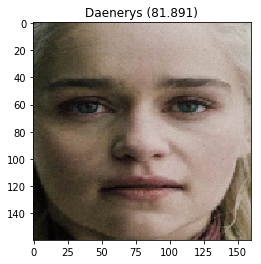

In [29]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()